# Resolve the transcriptional boost in gastrulation erythroid maturation data 

This tutorial shows how to analyze RNA velocity using cellDancer, including: (1) model estimation, (2) deriving cell fates in embedding level, and (3) pseudotime estimation.
 
Our advantage of resolving the existing difficulty of predicting genes that have transcriptional boost mentioned by [Bergen et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y) will be shown as well.

In the gastrulation erythroid maturation data, we selected 12,329 cells with 2,000 genes from haemato-endothelial progenitors, blood progenitors 1/2, and erythroid 1/2/3. The embryonic days are selected from E7.0, E7.25, E7.5, E7.75, E8.0, E8.25, and E8.5.

## Import packages

To run the notebook locally, [Installation](installation.html) could be referred to install the environment and dependencies.

In [1]:
# import packages
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.plotting as cdplt
from celldancer.plotting import colormap

## Load gastrulation erythroid maturation data 

The input data for cellDancer contains the abundances of unspliced RNA and spliced RNA. For the detail of obtaining the dataset and pre-processing, [Data Preparation](data_preprocessing.html) could be referred to. We followed the standard Data Preparation procedures in [scVelo](https://scvelo.readthedocs.io/) with default parameters except that we use 100 nearest neighbors for first-moment calculation.

The data of gastrulation erythroid maturation could be downloaded from [GastrulationErythroid_cell_type_u_s.csv](http:xxx/xxx/GastrulationErythroid_cell_type_u_s.csv). It could be loaded by ```pandas.read_csv('your_path/GastrulationErythroid_cell_type_u_s.csv')```. To load your own data, the dataframe should contain columns 'gene_name', 'unsplice', 'splice' ,'cellID' ,'clusters' ,'embedding1' , and 'embedding2.' For a detailed description of the data structure, [Preprocessing](data_preprocessing.html) could be referred.

In [2]:
cell_type_u_s_path='your_path/GastrulationErythroid_cell_type_u_s.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
cell_type_u_s

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Sox17,0.000000,0.043971,cell_363,Blood progenitors 2,3.460521,15.574629
1,Sox17,0.000000,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734
2,Sox17,0.000000,0.018161,cell_385,Blood progenitors 2,2.351203,15.267069
3,Sox17,0.000000,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825
4,Sox17,0.000000,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...
24657995,Gm47283,0.214961,1.145533,cell_139318,Erythroid3,8.032358,7.603037
24657996,Gm47283,0.300111,1.072944,cell_139321,Erythroid3,10.352904,6.446736
24657997,Gm47283,0.292607,1.199875,cell_139326,Erythroid3,9.464873,7.261099
24657998,Gm47283,0.266031,1.114659,cell_139327,Erythroid3,9.990495,7.243880


## Velocity estimation of sample genes

```celldancer.velocity_estimation.velocity()``` could be used to estimate the velocity. 

Here, 15 genes in ```gene_list``` will be estimated as an example. By default, the Deep Neural Network (DNN) will be trained at most 200 epochs. It will check the loss every 10 epochs. If the loss has no improvement in 3 checked epochs, the epoch will be ended, and the network at that time will be used for the estimation. If supported by equipment, parallel computing could be used to improve the speed, ```n_jobs``` could be adjusted according to demand.

After fitting, the predicted unspliced and spliced reads, alpha, beta, and gamma will be added to the original dataframe and returned.

In [3]:
gene_list=['Smarca2', 'Rbms2', 'Myo1b', 'Hba-x', 'Yipf5', 'Skap1', 'Smim1', 'Nfkb1', 'Sulf2', 'Blvrb', 'Hbb-y', 'Coro2b', 'Yipf5', 'Phc2', 'Mllt3']

loss_df, cellDancer_df=cd.velocity_estimation.velocity(cell_type_u_s,\
                                                       gene_list=gene_list,\
                                                       permutation_ratio=0.125,\
                                                       n_jobs=8)
cellDancer_df

Using /Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/analysis/CaseStudyNotebook/cellDancer_velocity_2022-06-15 12-12-06 as the output path.
Arranging genes for parallel job.
14  genes were arranged to  2  portions.



Velocity Estimation: 100%|██████████| 2/2 [00:38<00:00, 17.66s/it]                                                                                              
                                                                                                                                                                

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Mllt3,0.087552,0.061677,0.131864,0.347319,0.264903,0.304851,0.335579,0.111875,cell_363,Blood progenitors 2,3.460521,15.574629
1,1,Mllt3,0.042049,0.056451,0.096471,0.192440,0.253070,0.303873,0.335266,0.111875,cell_382,Blood progenitors 2,2.490433,14.971734
2,2,Mllt3,0.046162,0.073611,0.099587,0.222645,0.253818,0.304017,0.335363,0.111875,cell_385,Blood progenitors 2,2.351203,15.267069
3,3,Mllt3,0.119952,0.142994,0.156111,0.534318,0.270146,0.306117,0.336443,0.111875,cell_393,Blood progenitors 2,5.899098,14.388825
4,4,Mllt3,0.027221,0.136220,0.083502,0.221573,0.243896,0.304314,0.336083,0.111875,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172601,12324,Yipf5,0.098889,0.443361,0.090449,0.465709,0.041075,0.203301,0.469342,0.065887,cell_139318,Erythroid3,8.032358,7.603037
172602,12325,Yipf5,0.092605,0.521375,0.084460,0.529270,0.037166,0.202183,0.471642,0.065887,cell_139321,Erythroid3,10.352904,6.446736
172603,12326,Yipf5,0.108367,0.443695,0.098411,0.472935,0.042162,0.202911,0.469338,0.065887,cell_139326,Erythroid3,9.464873,7.261099
172604,12327,Yipf5,0.067904,0.431785,0.064602,0.432701,0.038083,0.204728,0.469054,0.065887,cell_139327,Erythroid3,9.990495,7.243880


## Visualization of sample genes' prediction and the correctly predicted transcriptional boost genes

Let’s visualize the predicted results pf each gene with ```celldancer.plotting.gene.scatter_gene()```.

From the figures below, the prediction of those genes that have transcriptional boost (Hba-x, Smim1, and Hbb-y) fulfills the biological cell type evolution of: (1) haemato-endothelial progenitors, (2) blood progenitors 1/2, and (3) erythroid.

This reflects the ability of our method to solve the transcriptional boost situation.

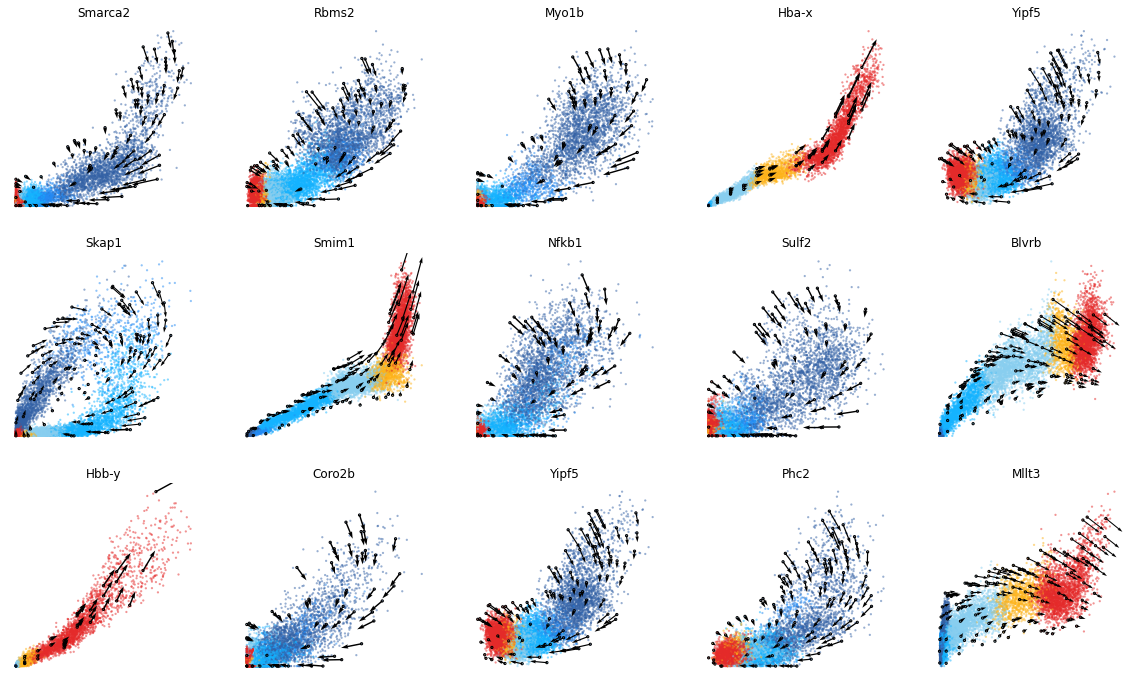

In [4]:
ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

## Load velocity estimation result of 2,000 genes

To display the prediction in embedding space and to estimate pseudotime by using all genes, all the 2,000 genes have already been predicted and could be downloaded from [GastrulationErythroid_cellDancer_estimation.csv](link). The .csv file could be loaded by ```pandas.read_csv()```.

In [5]:
# load the prediction result of all genes
cellDancer_df_path = 'your_path/GastrulationErythroid_cellDancer_estimation.csv'
cellDancer_df=pd.read_csv(cellDancer_df_path)

## Coumpute and visualize the prediction in embedding space

The prediction in the embedding space could be calculated with ```celldancer.compute_cell_velocity.compute()```. If not specified, all genes in cellDancer_df will be used to calculate the prediction in the embedding space. Following the method of [velocyto](https://velocyto.org/velocyto.py/index.html) and [scVelo](https://scvelo.readthedocs.io/), we project the velocity vectors of the cells into the low-dimensional embedding space.

After the calculation, the predicted direction in the embedding space, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```celldancer.plotting.cell.scatter_cell()``` could be used to display the predicted direction in embedding space.

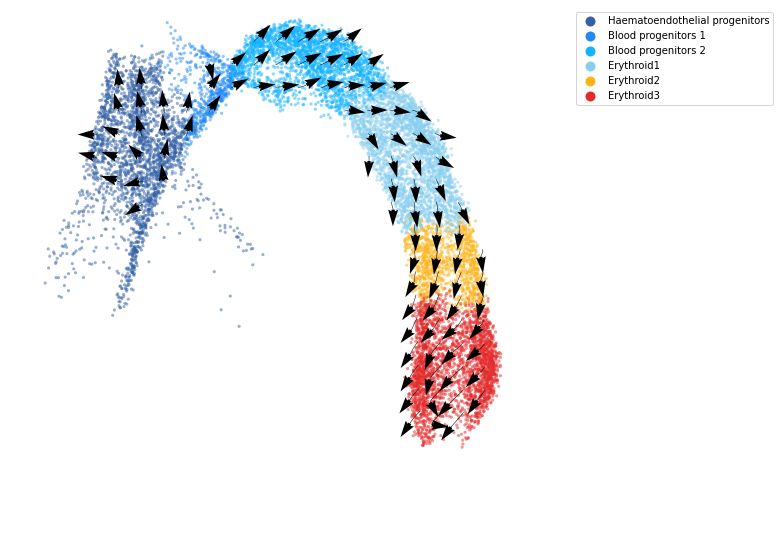

In [6]:
# compute cell velocity
cellDancer_df=cd.compute_cell_velocity.compute(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=10, speed_up=(100,100))

# plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
cdplt.cell.scatter_cell(ax,
                        cellDancer_df, 
                        colors=cdplt.colormap.colormap_erythroid, 
                        alpha=0.5, 
                        s=10,
                        velocity=True,
                        legend='on',
                        min_mass=15,
                        arrow_grid=(20,20),
                        custom_xlim=[-6,13], 
                        custom_ylim=[2,16], )
ax.axis('off')
plt.show()

In [7]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,Ift81,0.010658,0.026321,0.009261,0.029549,0.023595,0.042598,0.073999,0.039626,cell_363,Blood progenitors 2,3.460521,15.574629,0,NaN,NaN
1,1,Ift81,0.000000,0.044266,0.000946,0.037888,0.020649,0.042942,0.074502,0.039626,cell_382,Blood progenitors 2,2.490433,14.971734,1,NaN,NaN
2,2,Ift81,0.000000,0.064559,0.000885,0.055191,0.019326,0.042876,0.075031,0.039626,cell_385,Blood progenitors 2,2.351203,15.267069,2,NaN,NaN
3,3,Ift81,0.000000,0.020756,0.001014,0.017791,0.022149,0.043030,0.073879,0.039626,cell_393,Blood progenitors 2,5.899098,14.388825,3,NaN,NaN
4,4,Ift81,0.000000,0.013184,0.001037,0.011305,0.022633,0.043055,0.073676,0.039626,cell_398,Blood progenitors 2,4.823139,15.374831,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24657995,12324,Mcrip1,0.000000,1.128435,0.000157,1.125867,0.005920,0.038023,0.013131,0.051755,cell_139318,Erythroid3,8.032358,7.603037,12324,NaN,NaN
24657996,12325,Mcrip1,0.024356,0.970672,0.016090,1.428982,0.008338,0.037053,0.013950,0.051755,cell_139321,Erythroid3,10.352904,6.446736,12325,NaN,NaN
24657997,12326,Mcrip1,0.000000,0.899107,0.000175,0.897000,0.006575,0.037644,0.013522,0.051755,cell_139326,Erythroid3,9.464873,7.261099,12326,NaN,NaN
24657998,12327,Mcrip1,0.017375,1.398107,0.011387,1.729827,0.006885,0.037765,0.013271,0.051755,cell_139327,Erythroid3,9.990495,7.243880,12327,NaN,NaN


## Estimate Pseudotime

Based on the prediction in embedding space, the pseudotime could be estimated with ```celldancer.pseudo_time.pseudo_time()```.

In [8]:
%%capture

# set parameters
dt = 0.05
t_total = {dt:int(10/dt)} 
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time.pseudo_time(cellDancer_df=cellDancer_df, 
                                          grid=(20,20), 
                                          dt=dt, 
                                          t_total=t_total[dt], 
                                          n_repeats=n_repeats, 
                                          speed_up=(100,100),
                                          n_paths = 3,
                                          psrng_seeds_diffusion=[i for i in range(n_repeats)],
                                          activate_umap_paths_divider=False,
                                          n_jobs=8)

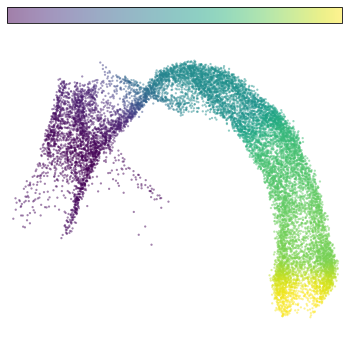

In [9]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, velocity=False, custom_xlim=(-5,11), custom_ylim=(4,18))
ax.axis('off')
plt.show()

The connection network below is another way to display pseudotime. The edge lengths indicate the time difference between nodes (the closer in pseudotime, the shorter the edge length). The sizes of the nodes are proportional to the 
pseudotime.

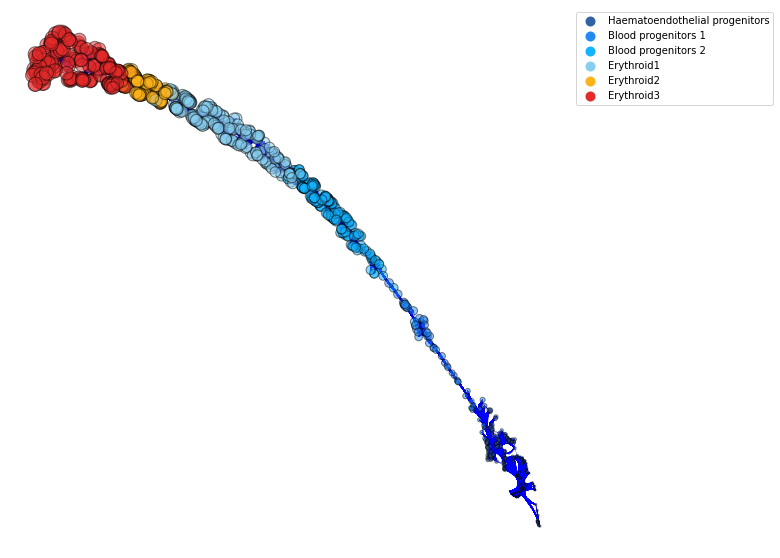

In [10]:
fig, ax= plt.subplots(figsize=(10,10))

cdplt.graph.graph(ax,
                  cellDancer_df,
                  node_layout='forcedirected',
                  use_edge_bundling=True,
                  node_colors=colormap.colormap_erythroid,
                  edge_length=3,
                  node_sizes='pseudotime',
                  colorbar='on',
                  legend='on')

## Pseudotime of gene

Let’s visualize the spliced RNA abundance of some sample genes based on pseudotime with ```celldancer.plotting.gene.scatter_gene()```.

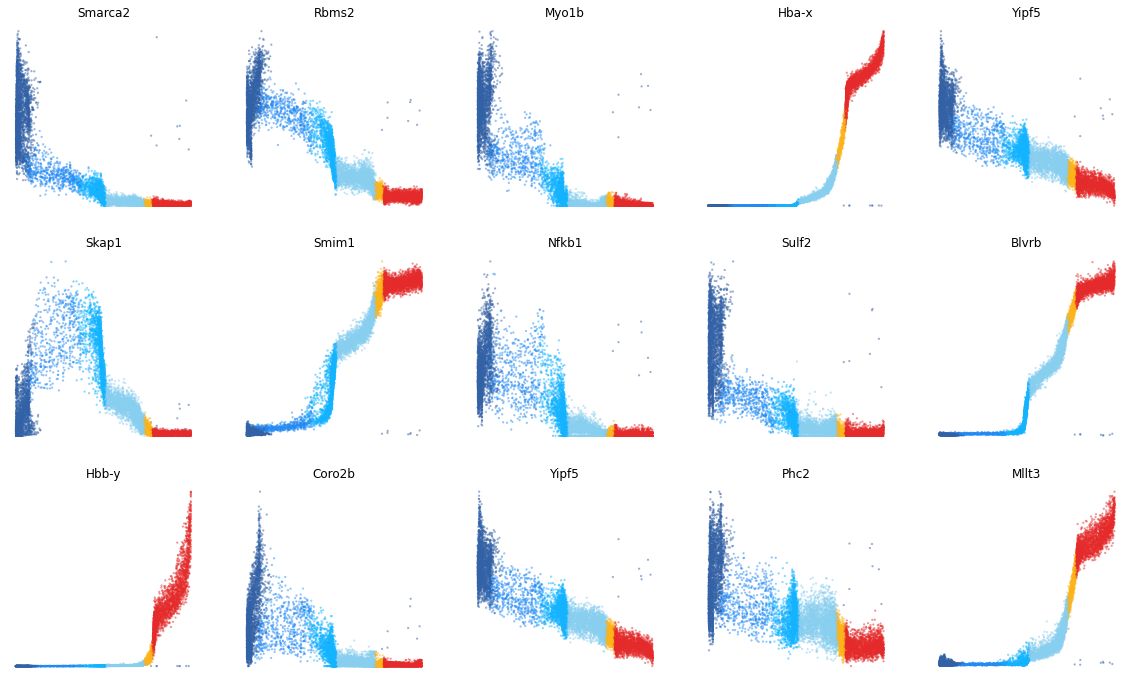

In [11]:
ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

## Coumpute and visualize the prediction in embedding space for MURK genes

In the study of [Barile et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y), Multiple Rate Kinetics (MURK) genes were deprecated when computing the prediction in embedding space. At first, the prediction of cell velocity in embedding space does not fulfill the biological cell type evolution. They identified MURK genes where the slope in Late Erythroid is significantly higher than the slope in Mid Erythroid. These genes were incorrectly predicted using scVelo. Only after removing these genes, the prediction in embedding space fulfills the biological cell type evolution.

To compare with them, we only use MURK genes in our prediction result to compute the prediction in embedding space. The MURK gene list could be obtained from [Additional file 3: Table S2](https://static-content.springer.com/esm/art%3A10.1186%2Fs13059-021-02414-y/MediaObjects/13059_2021_2414_MOESM3_ESM.csv) in [Barile et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y)'s work. It turns out that even with MURK genes, the cell fate predicted by our method in embedding space fulfills the biological cell type evolution.

Caution! Overwriting the 'velocity' columns.


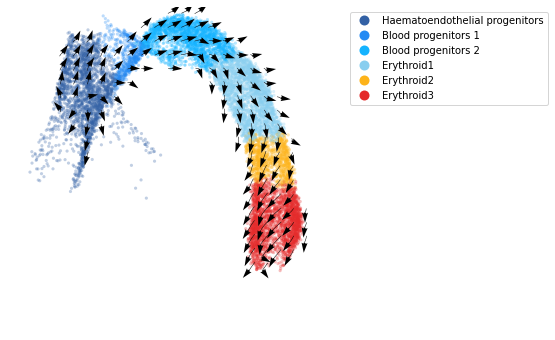

In [12]:
# load MURK gene list
murk_gene_pd=pd.read_csv('your_path/13059_2021_2414_MOESM3_ESM.csv')
murk_gene_list=list(murk_gene_pd['index'])

# compute cell velocity
cellDancer_df_murk=cd.compute_cell_velocity.compute(cellDancer_df=cellDancer_df,
                                                    gene_list=murk_gene_list,
                                                    projection_neighbor_choice='gene',
                                                    expression_scale='power10',
                                                    projection_neighbor_size=10,
                                                    speed_up=(100,100))
# plot cell velocity
fig, ax = plt.subplots(figsize=(6,6))
im = cdplt.cell.scatter_cell(ax,
                             cellDancer_df_murk, 
                             colors=colormap.colormap_erythroid, 
                             alpha=0.3, 
                             s=10,
                             velocity=True, 
                             custom_xlim=[-6,13], 
                             custom_ylim=[2,16], 
                             legend='on',
                             min_mass=15,
                             arrow_grid =(20,20))
ax.axis('off')
plt.show()